## Fine-tuning SpeechT5

In [1]:
!pip install git+https://github.com/hollance/transformers.git@6900e8ba6532162a8613d2270ec2286c3f58f57b

  Cloning https://github.com/hollance/transformers.git (to revision 6900e8ba6532162a8613d2270ec2286c3f58f57b) to /tmp/pip-req-build-j3vo4zht
  Running command git clone --filter=blob:none --quiet https://github.com/hollance/transformers.git /tmp/pip-req-build-j3vo4zht
  Running command git rev-parse -q --verify 'sha^6900e8ba6532162a8613d2270ec2286c3f58f57b'
  Running command git fetch -q https://github.com/hollance/transformers.git 6900e8ba6532162a8613d2270ec2286c3f58f57b
  Running command git checkout -q 6900e8ba6532162a8613d2270ec2286c3f58f57b
  Resolved https://github.com/hollance/transformers.git to commit 6900e8ba6532162a8613d2270ec2286c3f58f57b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.31.0.dev0-py3-none-any.whl size=7253513 sha256=dee3c240028f81b0805c1eb7001046e425906d780645ad78e9c7c1dc242ce0db
  Stored in directory: /home/ubuntu/

In [2]:
!pip install transformers datasets soundfile speechbrain accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.8/553.8 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 24.6 MB/s eta 0:00:00
  Attempting uninstall: ruamel.yaml
    Found existing installation: ruamel.yaml 0.17.32
    Uninstalling ruamel.yaml-0.17.32:
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'reader.py'
Consider using the `--user` option or check the permissions.



In [1]:
from datasets import load_dataset, Audio

dataset = load_dataset("facebook/voxpopuli", "de", split="train")
len(dataset)

Found cached dataset voxpopuli (/home/ubuntu/.cache/huggingface/datasets/facebook___voxpopuli/de/1.3.0/b5ff837284f0778eefe0f642734e142d8c3f574eba8c9c8a4b13602297f73604)


108473

In [2]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

In [3]:
from transformers import SpeechT5Processor

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

In [4]:
tokenizer = processor.tokenizer

In [5]:
dataset[0]

{'audio_id': '20120315-0900-PLENARY-14-de_20120315-16:29:53_3',
 'language': 1,
 'audio': {'path': '/home/ubuntu/.cache/huggingface/datasets/downloads/extracted/5fb2c7714bd65dd862d1d54ca4c2a70207ba5194f12909510ba7819b664d4083/train_part_0/20120315-0900-PLENARY-14-de_20120315-16:29:53_3.wav',
  'array': array([-0.1496582 , -0.14880371, -0.12649536, ..., -0.00421143,
          0.01269531,  0.03085327]),
  'sampling_rate': 16000},
 'raw_text': 'Natürlich gibt es Übergriffe des Herrscherhauses und des Sicherheitsapparates und der Saudis, die sich dahinter verstecken und die gerne Bahrain in ihren Staat integrieren würden.',
 'normalized_text': 'natürlich gibt es übergriffe des herrscherhauses und des sicherheitsapparates und der saudis die sich dahinter verstecken und die gerne bahrain in ihren staat integrieren würden.',
 'gender': 'male',
 'speaker_id': '2229',
 'is_gold_transcript': True,
 'accent': 'None'}

In [6]:
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}


vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/108473 [00:00<?, ? examples/s]

In [7]:
dataset_vocab - tokenizer_vocab

{' ', '1', 'ß', 'ä', 'ö', 'ü'}

In [8]:
replacements = [
    ('ä', "a"),
    ('ß', "b"),
    ('ö', "o"),
    ('ü', "u"),
    ('1', "one"),
]


def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["normalized_text"] = inputs["normalized_text"].replace(src, dst)
    return inputs


dataset = dataset.map(cleanup_text)

Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/facebook___voxpopuli/de/1.3.0/b5ff837284f0778eefe0f642734e142d8c3f574eba8c9c8a4b13602297f73604/cache-3d694026caeb29bc.arrow


In [9]:
from collections import defaultdict

speaker_counts = defaultdict(int)

for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1

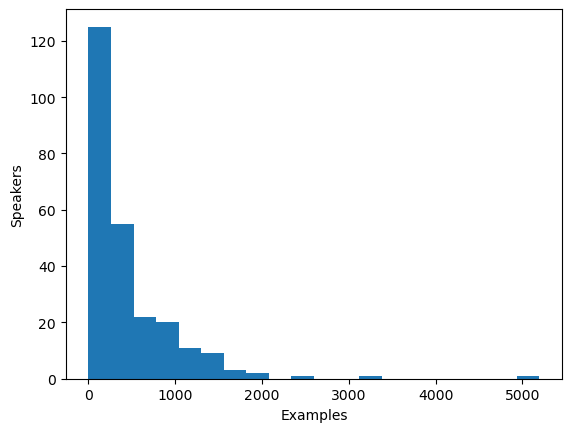

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

In [11]:
def select_speaker(speaker_id):
    return 100 <= speaker_counts[speaker_id] <= 400


dataset = dataset.filter(select_speaker, input_columns=["speaker_id"])

Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/facebook___voxpopuli/de/1.3.0/b5ff837284f0778eefe0f642734e142d8c3f574eba8c9c8a4b13602297f73604/cache-5b1abb80aaf66832.arrow


In [12]:
len(set(dataset["speaker_id"]))

81

In [13]:
len(dataset)

20081

## Speaker embeddings

In [14]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)


def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

### Processing the dataset

In [15]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

In [16]:
processed_example = prepare_dataset(dataset[0])
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

In [17]:
processed_example["speaker_embeddings"].shape

(512,)

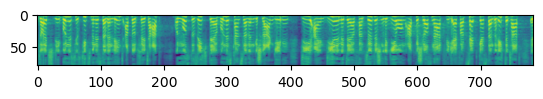

In [18]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [19]:
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names)

Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/facebook___voxpopuli/de/1.3.0/b5ff837284f0778eefe0f642734e142d8c3f574eba8c9c8a4b13602297f73604/cache-5370270f3aef77aa.arrow


In [20]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200


dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])
len(dataset)

Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/facebook___voxpopuli/de/1.3.0/b5ff837284f0778eefe0f642734e142d8c3f574eba8c9c8a4b13602297f73604/cache-6aafb90eb16fe36d.arrow


15735

In [21]:
dataset = dataset.train_test_split(test_size=0.1)

In [22]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [23]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

In [24]:
from transformers import SpeechT5ForTextToSpeech

model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

In [25]:
from functools import partial

# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(model.generate, use_cache=True)

In [26]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="speecht5_finetuned_voxpopuli_de",  # change to a repo name of your choice
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=2,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

In [27]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

/home/ubuntu/kj_learning/Audio-AI/text_to_speech/speecht5_finetuned_voxpopuli_de is already a clone of https://huggingface.co/karanjakhar/speecht5_finetuned_voxpopuli_de. Make sure you pull the latest changes with `repo.git_pull()`.


In [28]:
trainer.train()

/opt/conda/envs/pytorch/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,0.526600,0.486761
2000,0.503100,0.473518


RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [28]:
kwargs = {
     "dataset_tags": "facebook/voxpopuli",
    "finetuned_from": "microsoft/speecht5_tts",
    "tasks": "text-to-speech",
}

In [29]:
trainer.push_to_hub(**kwargs)

Upload file pytorch_model.bin:   0%|          | 1.00/551M [00:00<?, ?B/s]

Upload file runs/Jul27_19-42-53_ip-172-31-93-96/events.out.tfevents.1690487017.ip-172-31-93-96.10818.0:   0%| …

Upload file training_args.bin:   0%|          | 1.00/4.06k [00:00<?, ?B/s]

To https://huggingface.co/karanjakhar/speecht5_finetuned_voxpopuli_de
   52385ee..92f4b0c  main -> main

To https://huggingface.co/karanjakhar/speecht5_finetuned_voxpopuli_de
   92f4b0c..390bff8  main -> main



'https://huggingface.co/karanjakhar/speecht5_finetuned_voxpopuli_de/commit/92f4b0cef383d621fbe6ef95b2c2910e05909d78'